In [1]:

from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from scipy.stats import expon
import pandas as pd
import numpy as np


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import brier_score

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [2]:
from sklearn.datasets import make_classification
import numpy as np
n_samples = 1000
hazard_ratio = 2.0
random_state = 42

X, y = make_classification(n_samples=n_samples, random_state=random_state,n_informative= 10 )

In [3]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=n_samples, n_features=10, noise=1, random_state=n_samples)

In [4]:
time_event =  abs(y)
event = np.full(n_samples, True)
max_time = max(y)


In [5]:
from sksurv.util import Surv
yt = Surv.from_arrays(event=event, time=time_event)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, yt, test_size=0.2, random_state=random_state)

In [7]:
rsf = RandomSurvivalForest(random_state = random_state)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)



0.7153266331658291

In [32]:
## Create function to test all metrics in one swoop

def test_metrics(models, X_train = X_train, y_train = y_train, X_test = X_test, y_test=y_test):
    from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score, brier_score
)
    print(len(models))

    metrics_dic = {}
    # Max time calculation for evaluation
    max_time_test = round(max(y_test['time']),0)-1
    for model in models:
        scores = {}
    #c-index
        c_index = rsf.score(X_test, y_test)
        scores['C-index'] = round(c_index,3)


   
    # Brier score
        survs = model.predict_survival_function(X_test)

    
        preds = [fn(max_time_test) for fn in survs]
        score_brier = brier_score(y_train, y_test, preds, max_time_test)
        scores['Brier score'] = round(float(score_brier[1]),4)


        metrics_dic[f'{str(model)}'] = scores


    return metrics_dic

def

In [33]:
test_metrics([rsf])

1


{'RandomSurvivalForest(random_state=42)': {'C-index': 0.715,
  'Brier score': 0.0053}}

In [10]:
y_events = y_train[y_train["event"]]
train_min, train_max = y_events["time"].min(), y_events["time"].max()

y_events = y_test[y_test["event"]]
test_min, test_max = y_events["time"].min(), y_events["time"].max()

assert (
    train_min <= test_min < test_max < train_max
), "time range or test data is not within time range of training data."

In [22]:
# calculate Brier score

survs = rsf.predict_survival_function(X_test)

max_time_test = round(max(y_test['time']))
preds = [fn(max_time_test) for fn in survs]
score = brier_score(y_train, y_test, preds, max_time_test)
score

(array([513]), array([0.00525408]))

In [12]:
# calculate concordance index
rsf.score(X_test, y_test)

0.7153266331658291

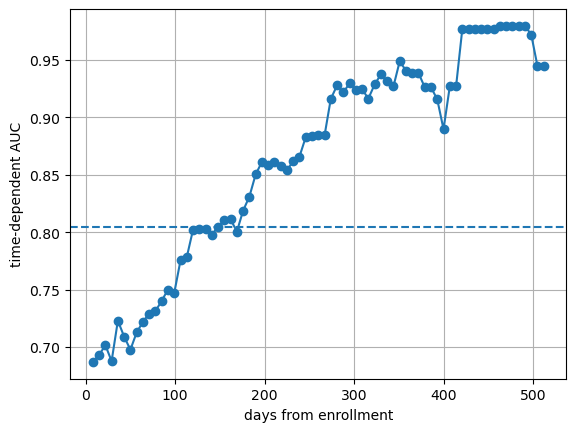

In [13]:
va_times = np.arange(8, max_time_test, 7)
rsf_risk_scores = rsf.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)


In [14]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.vstack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)

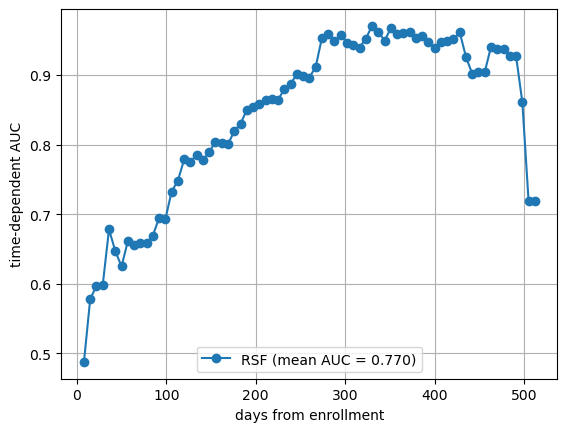

In [15]:

plt.plot(va_times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)